In [19]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

plt.rc('axes', unicode_minus=False)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (3,2)
mpl.rcParams['figure.dpi'] = 100

In [20]:
LOGS = {
    "normal": "../run-logs/logs-class,vessel,wildfire,multiclass-4000-1729319679",
    "overload": "../run-logs/logs-class,vessel,wildfire,multiclass,segment-4000-1729324321",
    "noapi": "../run-logs/logs-class,vessel,wildfire,multiclass-4000-1729328480",
}

In [21]:
logs = []

inflight_logs = []

# log types we need
# temp -> C
# battery -> mWh
# solar -> mWh
# comms -> mWh
# rpi -> mWh
# sat -> mWh
# len(fq) -> int
# idle -> bool

for k, v in LOGS.items():
    min_t = None
    with open(os.path.join(v, "monitor.log")) as f:
        for line in f:
            try:
                if "current temp" in line:
                    s = line.strip().split()

                    t = datetime.datetime.strptime(f"{s[1]} {s[2]}", "%Y/%m/%d %H:%M:%S.%f")

                    logs.append({
                        "type": "temp_C",
                        "experiment": k,
                        "time": t,
                        "value": float(s[-1])
                    })
                elif "outgoing (sat):" in line:
                    # [monitor] 2024/10/17 08:12:57.245135 energy.go:105: solar: 11.463396mWh, outgoing (sat): 2.571056mWh, outgoing (RPi): 0.544663mWh, outgoing (comms): 0.000000mWh charge: 40258.402060mWh (70.014612%) elapsed 232312us

                    s = line.strip().split()
                    t = datetime.datetime.strptime(f"{s[1]} {s[2]}", "%Y/%m/%d %H:%M:%S.%f")

                    elapsed_us = float(s[19][:-len("us")])

                    logs.append({
                        "type": "battery_mWh",
                        "time": t,
                        "experiment": k,
                        "value": float(s[16][:-len("mWh")])
                    })

                    logs.append({
                        "type": "solar_mW",
                        "time": t,
                        "experiment": k,
                        "value": float(s[5][:-len("mWh,")]) * 3600 / (elapsed_us / 1e6)
                    })

                    logs.append({
                        "type": "comms_mW",
                        "time": t,
                        "experiment": k,
                        "value": float(s[14][:-len("mWh")]) * 3600 / (elapsed_us / 1e6)
                    })

                    logs.append({
                        "type": "rpi_mW",
                        "time": t,
                        "experiment": k,
                        "value": float(s[11][:-len("mWh,")]) * 3600 / (elapsed_us / 1e6)
                    })

                    logs.append({
                        "type": "sat_mW",
                        "time": t,
                        "experiment": k,
                        "value": float(s[8][:-len("mWh,")]) * 3600 / (elapsed_us / 1e6)
                    })

                    logs.append({
                        "type": "total_mW",
                        "time": t,
                        "experiment": k,
                        "value": (float(s[5][:-len("mWh,")]) - float(s[8][:-len("mWh,")])) * 3600 / (elapsed_us / 1e6)
                    })

                    # logs.append({
                    #     "type": "elapsed_us",
                    #     "time": t,
                    #     "value": float(s[19][:len("us")])
                    # })

            except Exception as e:
                print(e)
                print(line)
                break

    with open(os.path.join(v, "tfaas.log")) as f:
        for line in f:
            try:
                if "len(fq)" in line:
                    # [tf] 2024/10/17 08:12:37.629381 rproxy.go:277: state: busy, len(fq) == 0
                    s = line.strip().split()

                    t = datetime.datetime.strptime(f"{s[1]} {s[2]}", "%Y/%m/%d %H:%M:%S.%f")

                    logs.append({
                        "type": "len_fq",
                        "time": t,
                        "experiment": k,
                        "value": int(s[8])
                    })
                    logs.append({
                        "type": "idle",
                        "time": t,
                        "experiment": k,
                        "value": s[5] == "idle,"
                    })
                elif "inflight[" in line:

                    # [tf] 2024/10/17 16:22:20.266393 rproxy.go:338: inflight[class] == 2
                    s = line.strip().split()

                    t = datetime.datetime.strptime(f"{s[1]} {s[2]}", "%Y/%m/%d %H:%M:%S.%f")

                    f = s[4][len("inflight["):-len("]")]

                    inflight_logs.append({
                        "time": t,
                        "func": f,
                        "experiment": k,
                        "value": int(s[6])
                    })

            except Exception as e:
                print(e)
                print(line)
                break

df = pd.DataFrame(logs, columns=["time", "type", "experiment", "value"])
# df["reltime"] = (df["time"] - df["time"].min()).dt.total_seconds()

inflight_df = pd.DataFrame(inflight_logs, columns=["time", "func", "experiment", "value"])
# inflight_df["reltime"] = (inflight_df["time"] - df["time"].min()).dt.total_seconds()

In [22]:
df.head()

,time,type,experiment,value
0,2024-10-19 06:36:54.801399,temp_C,normal,38.5
1,2024-10-19 06:36:54.809214,battery_mWh,normal,34500.091087
2,2024-10-19 06:36:54.809214,solar_mW,normal,47055.051564
3,2024-10-19 06:36:54.809214,comms_mW,normal,0.0
4,2024-10-19 06:36:54.809214,rpi_mW,normal,2634.124256


In [23]:
# df.dropna(inplace=True)

In [24]:

min_t = {}
for k in LOGS.keys():
    print(k)
    min_t[k] = df[df["experiment"] == k]["time"].min()
    print(min_t[k])

df["reltime"] = df.apply(lambda x: (x["time"] - min_t[x["experiment"]]).total_seconds() + 4000, axis=1)
inflight_df["reltime"] = inflight_df.apply(lambda x: (x["time"] - min_t[x["experiment"]]).total_seconds() + 4000, axis=1)

normal
2024-10-19 06:35:28.570335
overload
2024-10-19 07:52:14.510752
noapi
2024-10-19 09:01:33.902104


In [25]:
df.head()

,time,type,experiment,value,reltime
0,2024-10-19 06:36:54.801399,temp_C,normal,38.5,4086.231064
1,2024-10-19 06:36:54.809214,battery_mWh,normal,34500.091087,4086.238879
2,2024-10-19 06:36:54.809214,solar_mW,normal,47055.051564,4086.238879
3,2024-10-19 06:36:54.809214,comms_mW,normal,0.0,4086.238879
4,2024-10-19 06:36:54.809214,rpi_mW,normal,2634.124256,4086.238879


In [26]:
inflight_df.head()

,time,func,experiment,value,reltime
0,2024-10-19 06:48:17.230977,wildfire,normal,0,4768.660642
1,2024-10-19 06:48:17.231032,multiclass,normal,0,4768.660697
2,2024-10-19 06:48:17.231067,class,normal,0,4768.660732
3,2024-10-19 06:48:17.231093,vessel,normal,0,4768.660758
4,2024-10-19 06:48:17.231237,vessel,normal,0,4768.660902


/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_72497/1625020459.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_data["value"] = battery_data["value"]/BATTERY*100


Text(0.5, 0, 'Time (s)')

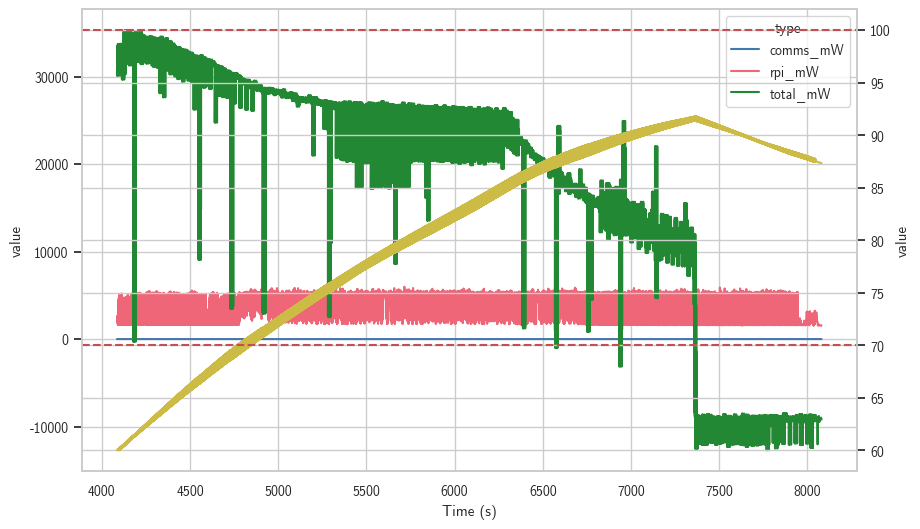

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
BATTERY = 57.5 * 1e3

energy_data = df[(df["type"] == "total_mW") | (df["type"] == "comms_mW") | (df["type"] == "rpi_mW")]
sns.lineplot(data=energy_data, x="reltime", y="value", ax=ax, hue="type")

battery_data = df[df["type"] == "battery_mWh"]
battery_data["value"] = battery_data["value"]/BATTERY*100

sns.lineplot(data=battery_data, x="reltime", y="value", ax=ax2, color=pal[3])
ax2.axhline(y=100, color='r', linestyle='--')
ax2.axhline(y=70, color='r', linestyle='--')

# ax.legend(["Solar", "Comms", "RPi", "Sat"], loc='upper left')
ax.set_xlabel("Time (s)")

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_72497/2229778475.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_data["value"] = battery_data["value"]/BATTERY*100


[(3000.0, 8000.0)]

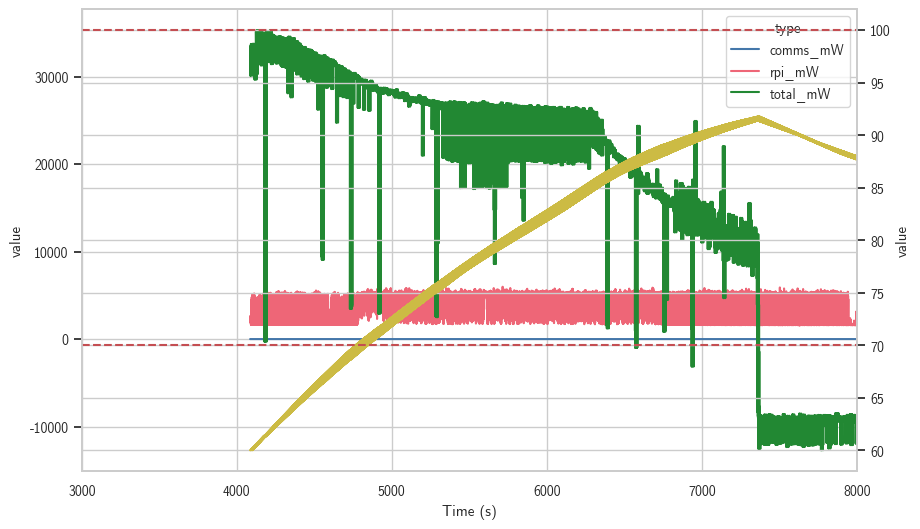

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
BATTERY = 57.5 * 1e3

energy_data = df[(df["type"] == "total_mW") | (df["type"] == "comms_mW") | (df["type"] == "rpi_mW")]
sns.lineplot(data=energy_data, x="reltime", y="value", ax=ax, hue="type")

battery_data = df[df["type"] == "battery_mWh"]
battery_data["value"] = battery_data["value"]/BATTERY*100

sns.lineplot(data=battery_data, x="reltime", y="value", ax=ax2, color=pal[3])
ax2.axhline(y=100, color='r', linestyle='--')
ax2.axhline(y=70, color='r', linestyle='--')

# ax.legend(["Solar", "Comms", "RPi", "Sat"], loc='upper left')
ax.set_xlabel("Time (s)")

ax.set(xlim=(3000, 8000))

Text(0.5, 0, 'Time (s)')

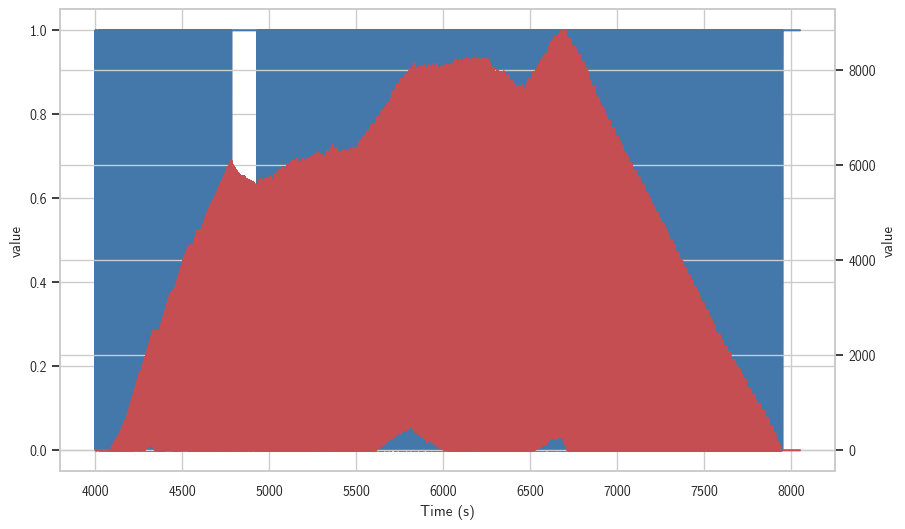

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

ax2 = ax.twinx()

sns.lineplot(data=df[df["type"] == "idle"], x="reltime", y="value", ax=ax)
sns.lineplot(data=df[df["type"] == "len_fq"], x="reltime", y="value", ax=ax2, color='r')
ax.set_xlabel("Time (s)")

In [30]:
df[df["type"] == "temp_C"]

,time,type,experiment,value,reltime
0,2024-10-19 06:36:54.801399,temp_C,normal,38.5,4086.231064
7,2024-10-19 06:36:55.804876,temp_C,normal,38.6,4087.234541
14,2024-10-19 06:36:56.811811,temp_C,normal,38.6,4088.241476
21,2024-10-19 06:36:57.816294,temp_C,normal,38.5,4089.245959
28,2024-10-19 06:36:58.821574,temp_C,normal,38.4,4090.251239
...,...,...,...,...,...
186291,2024-10-19 10:08:54.586927,temp_C,noapi,36.4,8040.684823
186298,2024-10-19 10:08:55.592742,temp_C,noapi,36.4,8041.690638
186305,2024-10-19 10:08:56.596511,temp_C,noapi,36.2,8042.694407
186312,2024-10-19 10:08:57.600842,temp_C,noapi,36.2,8043.698738


Text(0.5, 0, 'Time (s)')

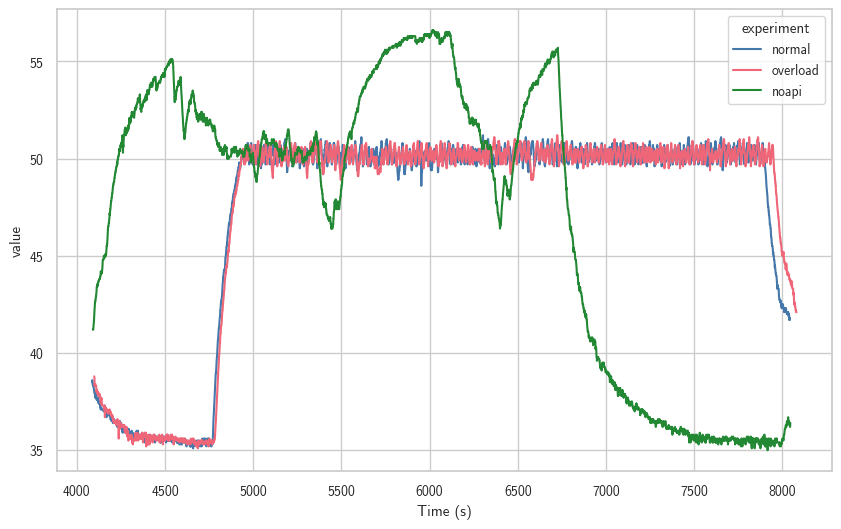

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df[df["type"] == "temp_C"], x="reltime", y="value", hue="experiment", ax=ax, estimator=None)
ax.set_xlabel("Time (s)")

webf NOT subset; don't know how to subset; dropped


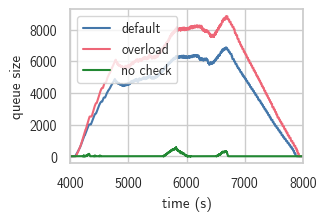

In [32]:
# First plot: idle periods and queue size

MIN_T = 4000
MAX_T = 8000

# get a list of idle periods
# busy_periods = []
# idle = True
# for k, g in df[df["type"] == "idle"].iterrows():
#     if not g["value"] == idle:
#         busy_periods.append(g["reltime"])
#         idle = not idle

len_fq = df[df["type"] == "len_fq"].copy()
len_fq = len_fq[(len_fq["reltime"] > MIN_T) & (len_fq["reltime"] < MAX_T)]
g = sns.lineplot(data=len_fq, x="reltime", y="value", hue="experiment", legend=False)

# for bp in range(1, len(busy_periods), 2):
#     # make a box
#     start = busy_periods[bp]

#     if start > MAX_T:
#         break

#     end = busy_periods[bp+1] if bp+1 < len(busy_periods) else MAX_T
#     g.axvspan(start, end, color='gray', alpha=0.5)

g.set_xlabel("time (s)")
g.set_ylabel("queue size")

# add a legend
handles, labels = g.get_legend_handles_labels()
handles.append(mpl.lines.Line2D([0], [0], color=pal[0]))
labels.append("default")
handles.append(mpl.lines.Line2D([0], [0], color=pal[1]))
labels.append("overload")
handles.append(mpl.lines.Line2D([0], [0], color=pal[2]))
labels.append("no check")
g.legend(handles=handles, labels=labels, loc='upper left')

g.set(xlim=(MIN_T, MAX_T))
plt.savefig("compare-queue-size.pdf", bbox_inches='tight')

webf NOT subset; don't know how to subset; dropped


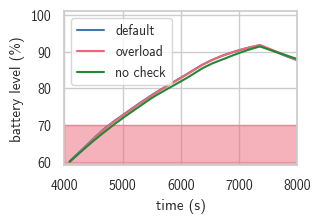

In [33]:
# third graph! battery level

local_df = df[(df["reltime"] > MIN_T) & (df["reltime"] < MAX_T)].copy()

BATTERY = 57.5 * 1e3
battery_data = local_df[local_df["type"] == "battery_mWh"].copy()
battery_data["value"] = battery_data["value"]/BATTERY*100

g = sns.lineplot(data=battery_data, x="reltime", y="value", hue="experiment", legend=False)

# add a red area below 70%
g.axhspan(0, 70, color=pal[1], alpha=0.5)
g.set(ylim=(59, 101))
g.set(xlim=(MIN_T, MAX_T))
plt.xlabel("time (s)")
plt.ylabel("battery level (%)")
# add a legend
handles, labels = g.get_legend_handles_labels()
handles.append(mpl.lines.Line2D([0], [0], color=pal[0]))
labels.append("default")
handles.append(mpl.lines.Line2D([0], [0], color=pal[1]))
labels.append("overload")
handles.append(mpl.lines.Line2D([0], [0], color=pal[2]))
labels.append("no check")
g.legend(handles=handles, labels=labels, loc='upper left')

plt.savefig("compare-battery.pdf", bbox_inches='tight')

In [34]:
print(f"normal under 70%: {len(battery_data[(battery_data['experiment'] == 'normal') & (battery_data['value'] < 70)])/len(battery_data[(battery_data['experiment'] == 'normal')])}")
print(f"overload under 70%: {len(battery_data[(battery_data['experiment'] == 'overload') & (battery_data['value'] < 70)])/len(battery_data[(battery_data['experiment'] == 'overload')])}")
print(f"nocheck under 70%: {len(battery_data[(battery_data['experiment'] == 'noapi') & (battery_data['value'] < 70)])/len(battery_data[(battery_data['experiment'] == 'noapi')])}")

normal under 70%: 0.174002574002574
overload under 70%: 0.17467700258397933
nocheck under 70%: 0.19309100283578243


In [35]:
0.19309100283578243 / 0.17467700258397933

1.1054174274770383

webf NOT subset; don't know how to subset; dropped


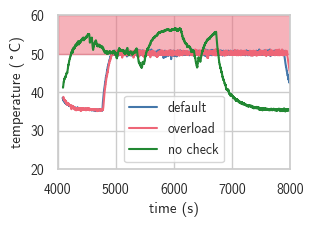

In [36]:
# fourth graph! temperature

local_df = df[(df["reltime"] > MIN_T) & (df["reltime"] < MAX_T)].copy()
local_df["value"] = local_df["value"]
temp_data = local_df[local_df["type"] == "temp_C"].set_index("time").drop(columns=["type", "reltime"])

temp_data_noapi = temp_data[temp_data["experiment"] == "noapi"].drop(columns=["experiment"])
temp_data_noapi = temp_data_noapi.rolling("1s").mean().reset_index()
temp_data_noapi["reltime"] = (temp_data_noapi["time"] - min_t["noapi"]).dt.total_seconds() + 4000

temp_data_normal = temp_data[temp_data["experiment"] == "normal"].drop(columns=["experiment"])
temp_data_normal = temp_data_normal.rolling("1s").mean().reset_index()
temp_data_normal["reltime"] = (temp_data_normal["time"] - min_t["normal"]).dt.total_seconds() + 4000

temp_data_overload = temp_data[temp_data["experiment"] == "overload"].drop(columns=["experiment"])
temp_data_overload = temp_data_overload.rolling("1s").mean().reset_index()
temp_data_overload["reltime"] = (temp_data_overload["time"] - min_t["overload"]).dt.total_seconds() + 4000

# temp_data = temp_data.groupby("experiment").rolling("1s").mean().reset_index()

g = sns.lineplot(data=temp_data_normal, x="reltime", y="value", color=pal[0])
g = sns.lineplot(data=temp_data_overload, x="reltime", y="value", color=pal[1])
g = sns.lineplot(data=temp_data_noapi, x="reltime", y="value", color=pal[2])

# add a red area above 50˚C

g.axhspan(50, 60, color=pal[1], alpha=0.5)
g.set(ylim=(20, 60))
g.set(xlim=(MIN_T, MAX_T))
plt.xlabel("time (s)")
plt.ylabel("temperature (˚C)")
# add a legend
handles, labels = g.get_legend_handles_labels()
handles.append(mpl.lines.Line2D([0], [0], color=pal[0]))
labels.append("default")
handles.append(mpl.lines.Line2D([0], [0], color=pal[1]))
labels.append("overload")
handles.append(mpl.lines.Line2D([0], [0], color=pal[2]))
labels.append("no check")
g.legend(handles=handles, labels=labels, loc='lower center')

plt.savefig("compare-temp.pdf", bbox_inches='tight')